In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(1234)


In [3]:
X_train = pd.read_csv('../../Data/X_train.csv')
y_train = pd.read_csv('../../Data/y_train.csv')

In [5]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical features: {categorical_features}")

drop_cols = []
if 'User_ID' in X_train.columns:
    drop_cols.append('User_ID')

numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('drop', 'drop', drop_cols)
    ], remainder='passthrough'
)

Categorical features: ['User_ID', 'Gender', 'Social_Media_Platform']


I created the preprocessing steps into a function so that they can be imputed into a pipeline later on. (because this is a random forest, I chose to not scale the data). I printed out the categorical features to double chekc they were correct. 

In [6]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressar', RandomForestRegressor(random_state=1234))
])

param_grid = {
    'regressar__n_estimators': [100, 200],
    'regressar__max_depth': [10, 20],
    'regressar__min_samples_split': [2, 5],
    'regressar__min_samples_leaf': [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train.values.ravel())

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV MSE: {-grid_search.best_score_}")

best_forest = grid_search.best_estimator_

y_pred_train = best_forest.predict(X_train)

print(f"Training MSE: {mean_squared_error(y_train, y_pred_train)}")
print(f"Training R2: {r2_score(y_train, y_pred_train)}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END regressar__max_depth=10, regressar__min_samples_leaf=1, regressar__min_samples_split=2, regressar__n_estimators=100; total time=   0.4s
[CV] END regressar__max_depth=10, regressar__min_samples_leaf=1, regressar__min_samples_split=2, regressar__n_estimators=100; total time=   0.4s
[CV] END regressar__max_depth=10, regressar__min_samples_leaf=1, regressar__min_samples_split=2, regressar__n_estimators=100; total time=   0.6s
[CV] END regressar__max_depth=10, regressar__min_samples_leaf=1, regressar__min_samples_split=2, regressar__n_estimators=100; total time=   0.6s
[CV] END regressar__max_depth=10, regressar__min_samples_leaf=1, regressar__min_samples_split=2, regressar__n_estimators=100; total time=   0.4s
[CV] END regressar__max_depth=10, regressar__min_samples_leaf=1, regressar__min_samples_split=2, regressar__n_estimators=200; total time=   0.9s
[CV] END regressar__max_depth=10, regressar__min_samples_leaf=1, regr

Created the pipeline and inputed it into GridSearch using a StratifiedKFold to ensure no data leakage. Printed out best parameters as well as scoring metrics. 

In [7]:
start_time = time()
best_forest.fit(X_train, y_train.values.ravel())
end_time = time()
print(f"Random Forest Training Time: {end_time - start_time} seconds")

rf_accuracy = r2_score(y_train, y_pred_train)
print(f"Random Forest R2 on training data: {rf_accuracy}")


Random Forest Training Time: 0.5601203441619873 seconds
Random Forest R2 on training data: 0.9126260969436378


Ran a simple test to calculate training time and accuracy to have more potential ways to measure the performance of the model. 

Top 20 Feature Importances:
remainder__Stress_Level(1-10)             0.373727
remainder__Daily_Screen_Time(hrs)         0.320164
remainder__Sleep_Quality(1-10)            0.080293
remainder__Age                            0.040653
remainder__Days_Without_Social_Media      0.024280
remainder__Exercise_Frequency(week)       0.016733
cat__Social_Media_Platform_LinkedIn       0.006518
cat__User_ID_U204                         0.005777
cat__Social_Media_Platform_X (Twitter)    0.005755
cat__User_ID_U256                         0.005107
cat__Social_Media_Platform_YouTube        0.004086
cat__User_ID_U011                         0.004007
cat__Social_Media_Platform_Instagram      0.003653
cat__User_ID_U455                         0.003652
cat__Gender_Male                          0.003135
cat__User_ID_U171                         0.003099
cat__User_ID_U496                         0.003032
cat__User_ID_U227                         0.002781
cat__Gender_Female                        0.002692
cat

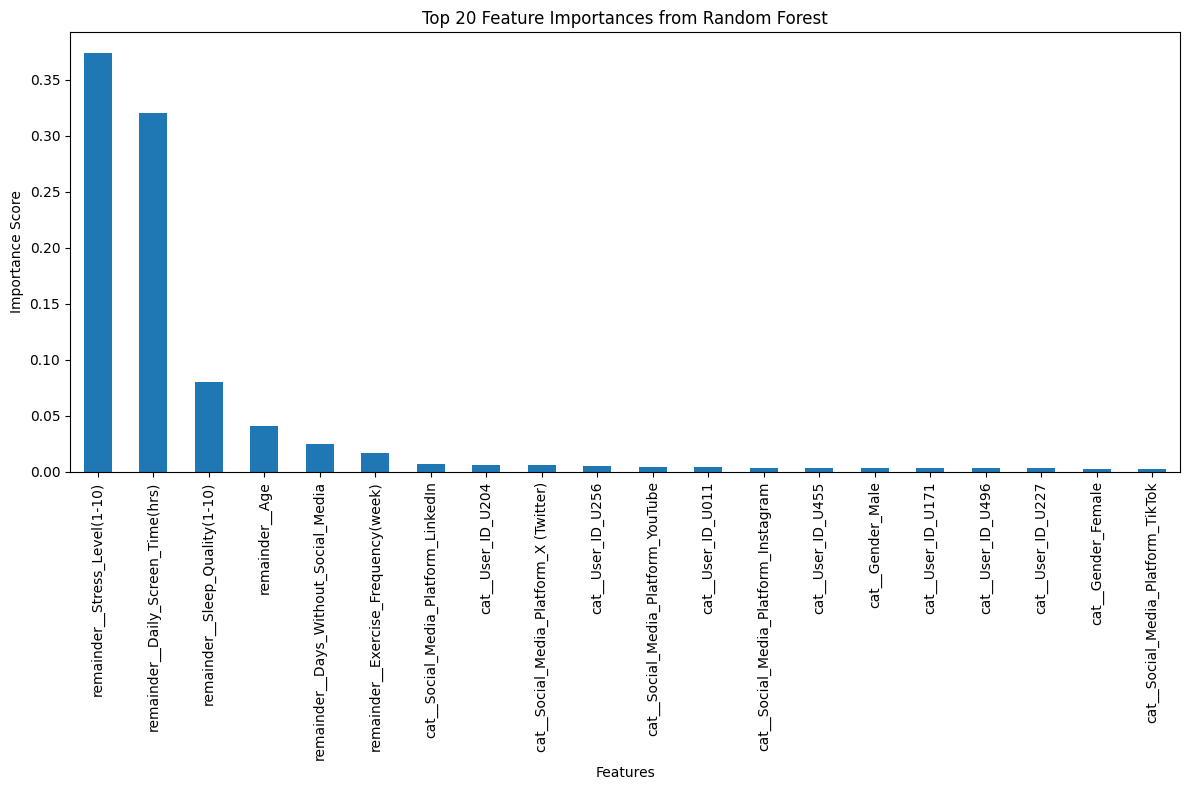

In [9]:
importances = best_forest.named_steps['regressar'].feature_importances_
feature_names = best_forest.named_steps['preprocessor'].get_feature_names_out()
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top 20 Feature Importances:")
print(feature_importances.head(20))
plt.figure(figsize=(12, 8))
feature_importances.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('../../Outputs/random_forest_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()


Specifically called the random forest regressor step in the pipeline to grab the top 20 features ranked in order of importance. 